<a href="https://colab.research.google.com/github/NishantNepal1/SimpleCVProject/blob/main/CATSDOGSCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS470 - Introduction to Artificial Intelligence

#### Prof. Ho-Jin Choi
#### School of Computing, KAIST
---

## Information
**Please write your student ID and name here!**
- Student ID: 20190882
- Name:Nishant Nepal

---

## Lab 1: Dog and Cat Breed Identification

In this assignment, you are going to train a convolutional neural network to classify images of dog and cats as their breeds. Please follow the steps below to continue this assignment.

### Guidelines
Copy this example to your Google Colab and edit it to complete your assignment. We should be able to reproduce your results using your code and pre-trained model. Please double-check if your code runs without error properly. Submissions failed to run or reproduce the results will get a substantial penalty.

### Extra points
TAs will rank the submissions based on the test accuracy and assign extra points according to the rank. (The baseline accuracy is roughly 85%.)
 
If you improve your model's accuracy using various techniques (e.g., more stacking layer, early stopping, etc.), then please write how to improve into the block at the bottom. 

### Deliverables

- Download your Colab notebook, and your pre-trained model (i.e., checkpoint), and submit a zip file in a format: [StudentID].zip. Please double-check that you load your pre-trained model properly.
- Your assignment should be submitted through KLMS. All other submissions (e.g., via email) will not be considered as valid submissions.

### Due date

- **23:59:59 May 17th (Tue).**
- Late submission is allowed until 23:59:59 May 17th (Tue).
- Late submission will be applied 20% penalty.

In [ ]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

# DO NOT EDIT THE FOLLOWING LINES
# THESE LINES ARE FOR REPRODUCIBILITY
np.random.seed(1)
tf.random.set_seed(1)

### 1. Load the Oxford-IIIT Pet dataset
In this assignment, you will use the Oxford-IIIT pet dataset which contains 37 category pet images with roughly 200 images for each class. 

![Oxford-IIIT Pet Dataset](https://github.com/keai-kaist/CS470-Spring-2022-/blob/main/Lab2/May%205/images/oxford-iiit-pet.png?raw=true)

Please note that the images have large variations in scale, pose and lighting. Let's import and load the Oxford-IIIT pet dataset using TensorFlow Datasets:

In [ ]:
import tensorflow_datasets as tfds

labels = [
    'abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound',
    'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua',
    'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired',
    'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon',
    'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll',
    'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese',
    'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier',
]

dataset, metadata = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=True)
raw_train, raw_test = dataset['train'], dataset['test']

Let's visualize what some of these images and their corresponding training labels look like.

In [ ]:
print(metadata)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

'\nprint(labels)\nprint(f"\nTotal number of unique labels: {len(np.unique(labels))}")\nlabelEncDict = {name : ind for ind, name in enumerate(np.unique(labels))}\nfor k, v in labelEncDict.items():\n    print(f"{k:32} : {v}")\n'

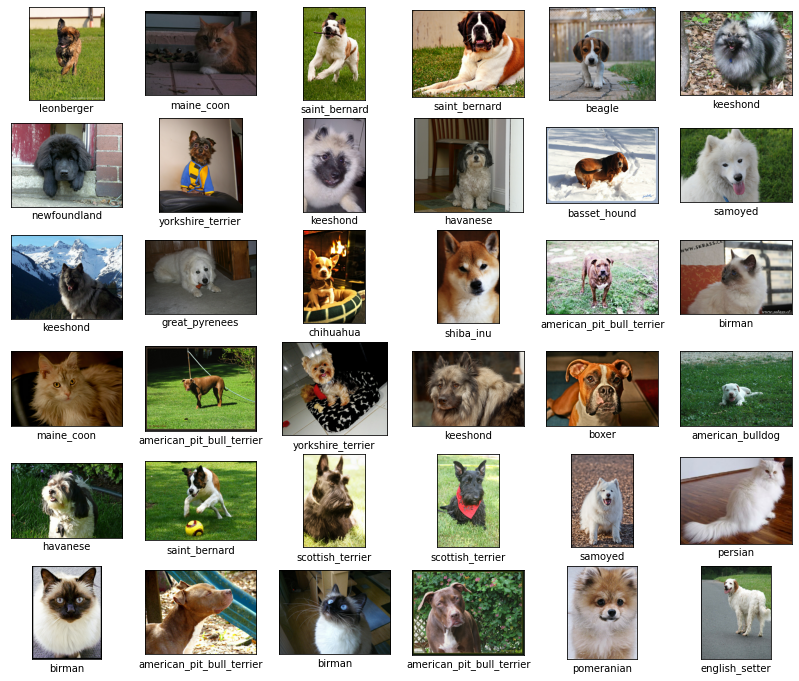

In [ ]:
plt.figure(figsize=(14, 12))

for index, (image, label) in enumerate(dataset['test'].take(36)):
    plt.subplot(6, 6, index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.xlabel(labels[label.numpy()])

"""
print(labels)
print(f"\nTotal number of unique labels: {len(np.unique(labels))}")
labelEncDict = {name : ind for ind, name in enumerate(np.unique(labels))}
for k, v in labelEncDict.items():
    print(f"{k:32} : {v}")
"""

### 2. Preprocess the dataset

#### Problem 1
Define a function to preprocess the dataset. The function should **scale the input channels** to a range of [-1, 1] and **resize the images** to a fixed size, `IMAGE_SIZE`.

In [ ]:
IMAGE_SIZE = (224, 224)

def preprocess(image, label):
    # TODO: Cast the image vector as tf.float32
    image = tf.cast(image, tf.float32)
    # TODO: Rescale the input channels to a range of [-1, 1]
    image = (image/127.5) - 1 
    # TODO: Resize the images to a fixes input size
    image = tf.image.resize(image, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
    
    return image, label

### END CODE HERE ###

#### Problem 2
Apply the defined preprocessing function to `raw_train` and `raw_test`. Then, shuffle the dataset and combine them into batches.

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1024

# TODO: Apply the defined preprocessing function to `raw_train` and `raw_test`
#       Then, shuffle the dataset and combine them into batches
### START CODE HERE ###
train = raw_train.map(preprocess)
#validation = raw_validation.map(preprocess)
test = raw_test.map(preprocess)
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
#validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)


image_batch, label_batch = next(iter(train_batches.take(1)))
print(image_batch.shape)
print(label_batch.shape)
### END CODE HERE ###

(32, 224, 224, 3)
(32,)


### 3. Build the model
In this assignment, we are going to train the convolutional neural network using transfer learning.

#### Problem 3
Load `InceptionV3` model without the final classification layer using `tf.keras.applications.InceptionV3`. Then, freeze the model to prevent it from being trained.

In [ ]:
# TODO: Load InceptionV3 model without the final classification layer
#       Then, freeze the model to prevent it from being trained
### START CODE HERE ###
IMG_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

# TODO: Load MobileNetV2 without the final classification layer
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

feature_batch = base_model(image_batch)
print(image_batch.shape,  '->', feature_batch.shape)
base_model.trainable = False
base_model.summary()
### END CODE HERE ###

(32, 224, 224, 3) -> (32, 5, 5, 2048)
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_376 (Batch  (None, 111, 111, 32  96         ['conv2d_376[0][0]']             
 Normalization)                 )                

#### Problem 4
Define a convolutional neural network using the loaded `InceptionV3` to classify images of dogs and cats as their breeds. Then, compile your model with appropriate parameters.

In [ ]:
# TODO: Define a convolutional neural network using the loaded InceptionV3
#       Then, compile your model with appropriate parameters
### START CODE HERE ###
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_layer = tf.keras.layers.Dense(37,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

# TODO: Add the classification layer
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

learning_rate = 0.0001

# TODO: Compile the model with the following paramters:
# - optimizer: RMSprop
# - loss: binary crossentropy
# - metrics: accuracy
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
              loss = "sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.summary()



### END CODE HERE ###

(32, 2048)
(32, 37)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_8   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 37)                75813     
                                                                 
Total params: 21,878,597
Trainable params: 75,813
Non-trainable params: 21,802,784
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


### 4. Train the model

#### Problem 5
Now, train the model at least 10 epochs.

In [ ]:
# TODO: Train the model at leat 10 epochs
### START CODE HERE ###


initial_epochs = 10

# Train the model
history = model.fit(
    train_batches,
    epochs=initial_epochs,
)

### END CODE HERE ###

Epoch 1/10
115/115 [==============================] - 25s 132ms/step - loss: 2.5818 - accuracy: 0.3758
Epoch 2/10
115/115 [==============================] - 18s 125ms/step - loss: 1.0765 - accuracy: 0.7715
Epoch 3/10
115/115 [==============================] - 18s 132ms/step - loss: 0.6297 - accuracy: 0.8495
Epoch 4/10
115/115 [==============================] - 18s 131ms/step - loss: 0.4708 - accuracy: 0.8791
Epoch 5/10
115/115 [==============================] - 19s 138ms/step - loss: 0.3897 - accuracy: 0.8976
Epoch 6/10
115/115 [==============================] - 18s 131ms/step - loss: 0.3393 - accuracy: 0.9101
Epoch 7/10
115/115 [==============================] - 18s 131ms/step - loss: 0.3033 - accuracy: 0.9163
Epoch 8/10
115/115 [==============================] - 18s 131ms/step - loss: 0.2758 - accuracy: 0.9255
Epoch 9/10
115/115 [==============================] - 18s 130ms/step - loss: 0.2543 - accuracy: 0.9302
Epoch 10/10
115/115 [==============================] - 18s 132ms/step - l

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

KeyError: ignored

#### Problem 6
To fine-tune the model, unfreeze the top layers of the model. Please note that you should carefully choose layers to be frozen. Then, compile the model again with appropriate parameters.

In [ ]:
# TODO: Unfreeze the top layers of the model
#       Compile the model with appropriate parameters
### START CODE HERE ###
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 200

# TODO: Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate/10),
              metrics=['accuracy'])
model.summary()

### END CODE HERE ###

#### Problem 7
Fine-tune the model at least 10 epochs.

In [ ]:
# TODO: Fine-tune the model at least 10 epochs
### START CODE HERE ###
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine_tuned = model.fit(
    train_batches,
     epochs=total_epochs,
     initial_epoch=initial_epochs,
     validation_data=test_batches)
### END CODE HERE ###

### 4. Evaluate accuracy

#### Problem 8
Evaluate the trained model using test dataset and print the test accuracy of the model.

In [ ]:
# TODO: Evaluate the model using test dataset
### START CODE HERE ###
loss0, accuracy0 = model.evaluate(test_batches)
### END CODE HERE ###

### 5. How to improve

If you have improved the performance of your model, please fill in this block.